# <center>ST590 Final Project</center>

#### <center>Pramodini Karwande and Ashley Ko </center>

## Introduction

**This section is in progress. I have started writing some preliminary things that we can use to form an introductory section**



We will be exploring data from `heart.csv`. It was obtained via kaggle.com. https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

We will be using this data set to classify individuals as either having heart disease or not. This is a binary data set.
We will use a classification tree, bagging, random forest and logistic regression to select and fit models and predict the presence of heart disease.

## Supervised Learning Concepts

In [ ]:
## TO DO: DESCRIBE SUPERVISED LEARNING CONCEPTS

In [328]:
# Import packages
import os
import sys
import warnings
import pandas as pd
import numpy as np
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns

# Set environment
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Remove warnings
warnings.filterwarnings("ignore")


# Set figure size
plt.rcParams["figure.figsize"] = (10,7)

# Spark Session builder
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.debug.maxToStringFields", "100").getOrCreate()

## Data Split

<p  style="color:#ff6633;"> Now read in a data set using `pandas on spark`</p>

In [329]:
# Read in data as pandas-on-Spark data frame
psdf_heart = ps.read_csv("heart.csv")
psdf_heart.head()

22/04/29 15:04:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/29 15:04:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [330]:
psdf_heart.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int32  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int32  
 4   Cholesterol     918 non-null    int32  
 5   FastingBS       918 non-null    int32  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int32  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int32  
dtypes: float64(1), int32(6), object(5)

22/04/29 15:04:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/29 15:04:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<p  style="color:#ff6633;"> Let's first see any missing values to handle the data properly. </p>

In [331]:
# check for null values
print(psdf_heart.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [332]:
sql_heart = psdf_heart.to_spark()

In [334]:
sql_train, sql_test = sql_heart.randomSplit([0.75, 0.25], seed = 1234)
print(sql_train.count(), sql_test.count())

686 232


In [335]:
pd_heart = sql_heart.toPandas()
pd_heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Exploratory Data Analysis

### Numerical Summaries

<p  style="color:#ff6633;"> Using pandas-on-Spark, below is the summary for the variables : `Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak` variables </p>

In [336]:
psdf_heart[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


From the summary table above, it is evident that there are potential outliers for `Cholesterol` and `RestingBP`. A resting blood pressure or cholesterol level of 0 is cause for concern. It could be that these values were not recorded or that these values are true measurements. We do not know for certain. Our concerns is that these observations might be over represented in either the test or training data and lead inaccurate model predictions or erroneously be selected as a good predictor for heart disease.

To assess the proportion of observations with either `Cholesterol` of 0 or `RestingBP` we obtained counts by filtering the `SPARK SQL` dataset accordingly.

First, let us look at the occurrences of a `RestingBP` of 0. The first value printed is the number of observations in the full data set, the second number is the count from the training data set, and the final number is the count from the test data set.

In [337]:
# Display counts for RestingBP of 0
print(sql_heart.filter(sql_heart.RestingBP == 0).count())

1


There is only a single observation with a `RestingBP` of 0. Because we cannot determine the reason for this value, we will continue to use this observation.

Now, let's examine counts for observations where `Cholesterol` is zero. The first value printed is the number of observations in the full data set and the second number is ratio of observations with heart disease and `Cholesterol` of 0 out of the total number of observations with heart disease.

In [338]:
# Display counts for Cholesterol of 0 and respective ratios for training and test data
print(sql_heart.filter(sql_heart.Cholesterol == 0).count(),
      sql_heart.filter(sql_heart.Cholesterol == 0)
      .filter(sql_heart.HeartDisease == 1).count()/
      sql_heart.filter(sql_heart.HeartDisease == 1).count())

172 0.2992125984251969


We calculated the proportion of observations with heart disease and cholesterol measurement of 0. This proportion is approximately 0.30 

There is a relatively weak correlation -0.246 between heart disease and cholesterol. However, given the general understanding of the relationship between heart disease, we decided to proceed with outlier observations and make note of this for further work.

In [339]:
psdf_heart.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000,0.254,-0.095,0.198,-0.382,0.259,0.282
RestingBP,0.254,1.000,0.101,0.070,-0.112,0.165,0.108
Cholesterol,-0.095,0.101,1.000,-0.261,0.236,0.050,-0.233
FastingBS,0.198,0.070,-0.261,1.000,-0.131,0.053,0.267
MaxHR,-0.382,-0.112,0.236,-0.131,1.000,-0.161,-0.400
Oldpeak,0.259,0.165,0.050,0.053,-0.161,1.000,0.404
HeartDisease,0.282,0.108,-0.233,0.267,-0.400,0.404,1.000


<p  style="color:#ff6633;"> Let's repeat above task to get mean and std for the given variables for HeartDisease based on sex. </p>

In [340]:
psdf_summ_group = psdf_heart.groupby('HeartDisease').agg(
    {'Age': ['mean', 'std'], 'RestingBP': ['mean', 'std'], 'Cholesterol': ['mean', 'std'],
     'MaxHR': ['mean', 'std'], 'Oldpeak': ['mean', 'std']})
psdf_summ_group

Age             RestingBP            Cholesterol                   MaxHR              Oldpeak          
                   mean       std        mean        std        mean         std        mean        std      mean       std
HeartDisease                                                                                                               
1             55.899606  8.727056  134.185039  19.828685  175.940945  126.391398  127.655512  23.386923  1.274213  1.151872
0             50.551220  9.444915  130.180488  16.499585  227.121951   74.634659  148.151220  23.288067  0.408049  0.699709

In [341]:
psdf_summ_sex = psdf_heart.groupby('Sex').agg(
    {'Age': ['mean', 'std'], 'RestingBP': ['mean', 'std'], 'Cholesterol': ['mean', 'std'],
     'MaxHR': ['mean', 'std'], 'Oldpeak': ['mean', 'std']})
psdf_summ_sex

Age             RestingBP            Cholesterol                   MaxHR              Oldpeak          
          mean       std        mean        std        mean         std        mean        std      mean       std
Sex                                                                                                               
F    52.492228  9.517593  132.212435  19.392638  241.196891   85.195441  146.139896  22.154902  0.668912  0.956865
M    53.782069  9.397864  132.445517  18.286739  187.513103  112.351444  134.325517  25.719191  0.945517  1.087154

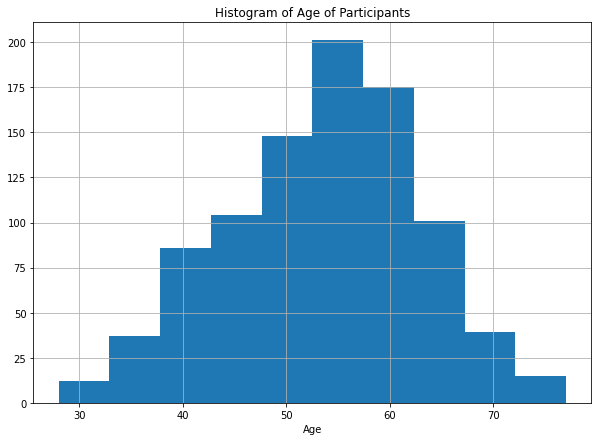

In [342]:
pd_heart.Age.hist(bins = 10)
plt.xlabel("Age")
plt.title("Histogram of Age of Participants")
plt.show()

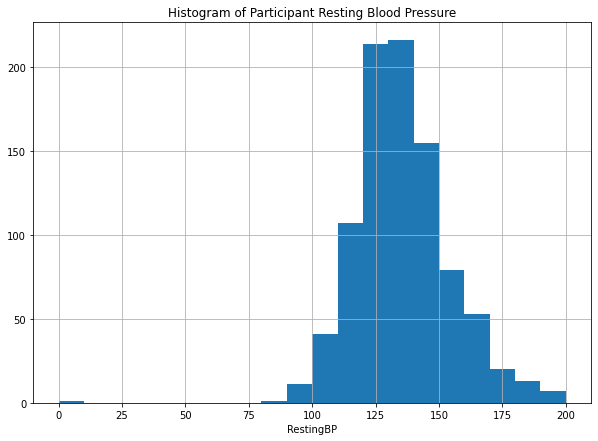

In [343]:
pd_heart.RestingBP.hist(bins = 20)
plt.xlabel("RestingBP")
plt.title("Histogram of Participant Resting Blood Pressure")
plt.show()

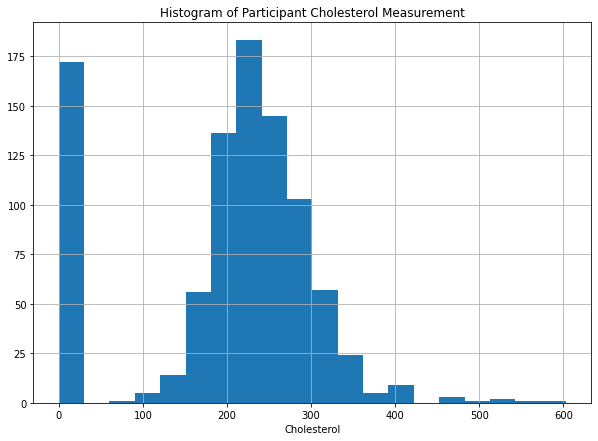

In [344]:
pd_heart.Cholesterol.hist(bins = 20)
plt.xlabel("Cholesterol")
plt.title("Histogram of Participant Cholesterol Measurement")
plt.show()

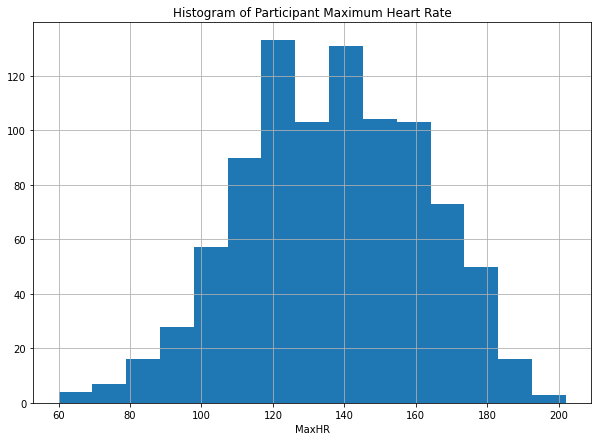

In [345]:
pd_heart.MaxHR.hist(bins = 15)
plt.xlabel("MaxHR")
plt.title("Histogram of Participant Maximum Heart Rate")
plt.show()

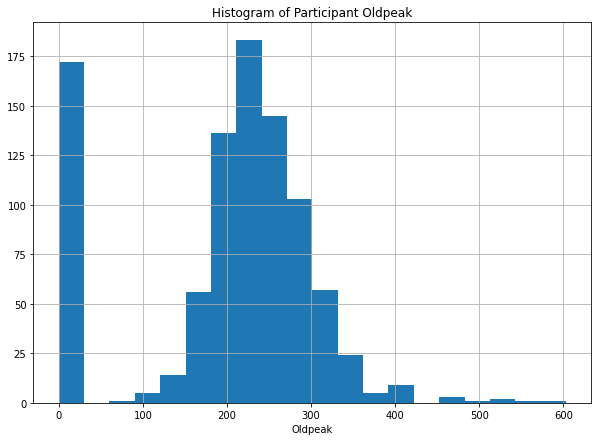

In [346]:
pd_heart.Cholesterol.hist(bins = 20)
plt.xlabel("Oldpeak")
plt.title("Histogram of Participant Oldpeak")
plt.show()

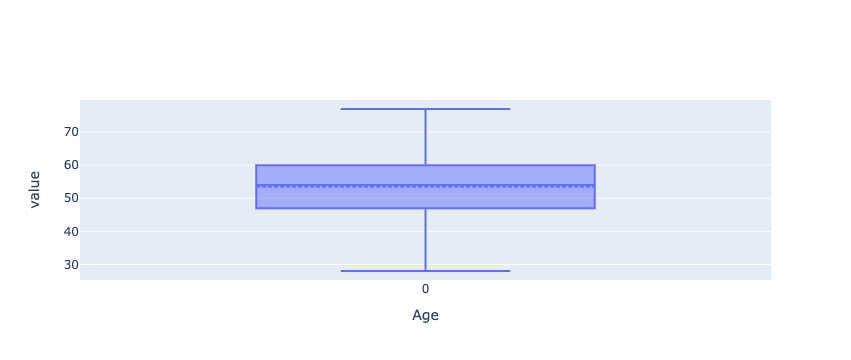

In [347]:
psdf_heart['Age'].plot.box()

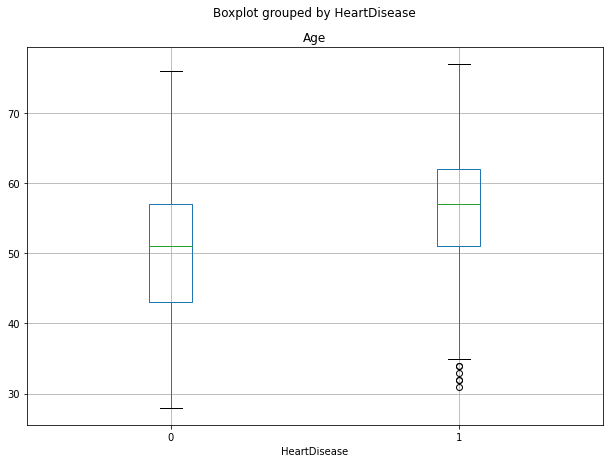

In [348]:
pd_heart.boxplot(column = ['Age'], by = 'HeartDisease')
plt.show()

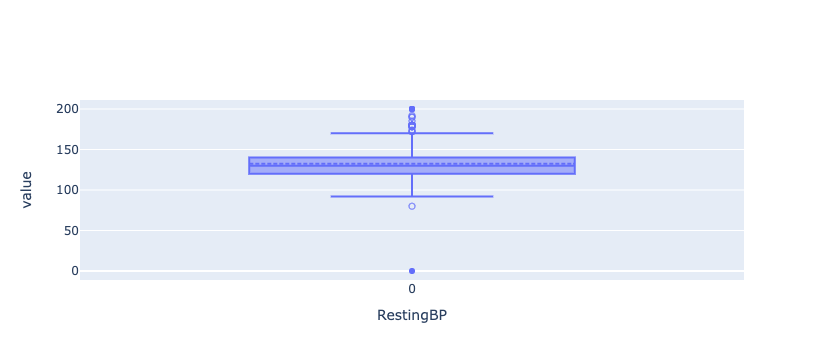

In [349]:
psdf_heart['RestingBP'].plot.box()

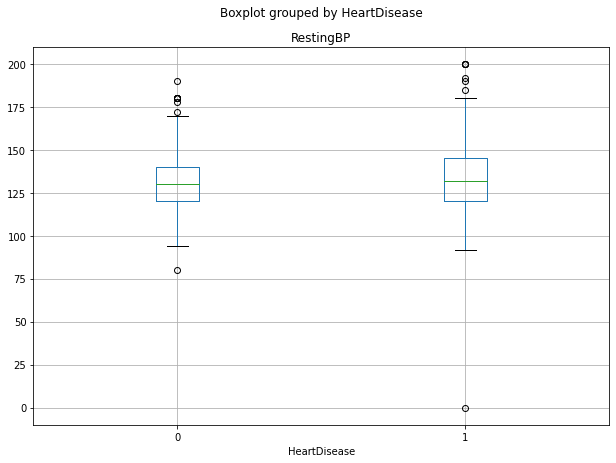

In [350]:
pd_heart.boxplot(column = ['RestingBP'], by = 'HeartDisease')
plt.show()

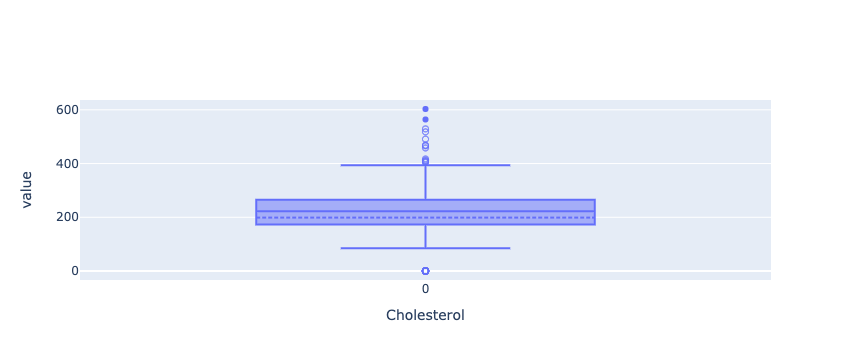

In [352]:
psdf_heart['Cholesterol'].plot.box()

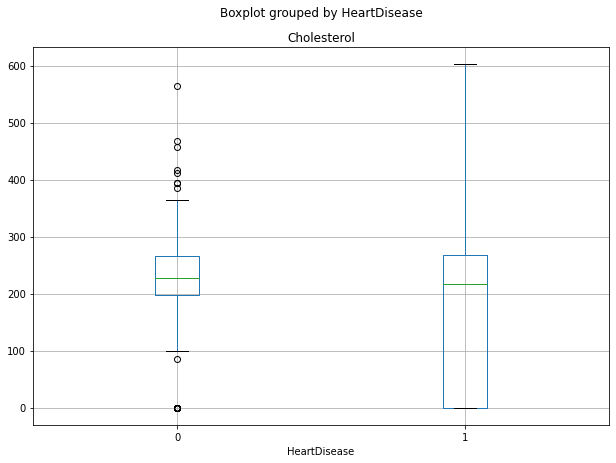

In [353]:
pd_heart.boxplot(column = ['Cholesterol'], by = 'HeartDisease')
plt.show()

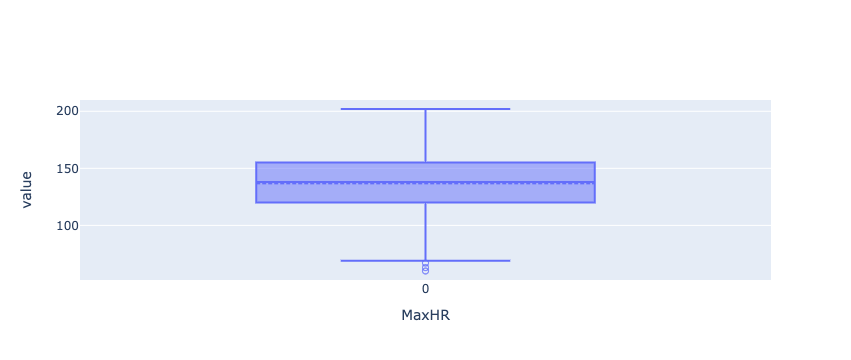

In [354]:
psdf_heart['MaxHR'].plot.box()

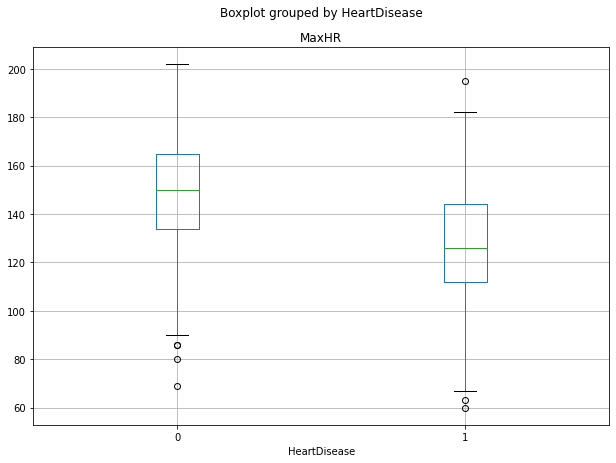

In [355]:
pd_heart.boxplot(column = ['MaxHR'], by = 'HeartDisease')
plt.show()

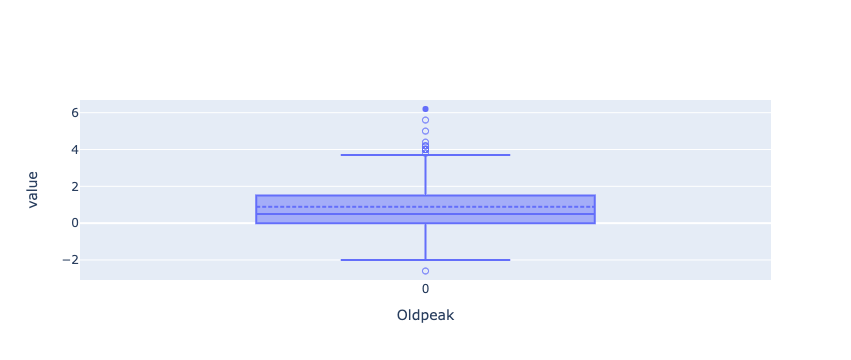

In [356]:
psdf_heart['Oldpeak'].plot.box()

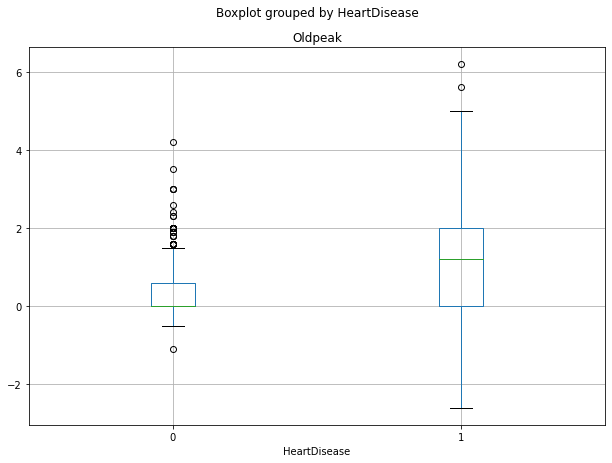

In [357]:
pd_heart.boxplot(column = ['Oldpeak'], by = 'HeartDisease')
plt.show()

In [358]:
sql_heart.crosstab('HeartDisease', 'Sex').show()

+----------------+---+---+
|HeartDisease_Sex|  F|  M|
+----------------+---+---+
|               1| 50|458|
|               0|143|267|
+----------------+---+---+



In [359]:
sql_heart.crosstab('HeartDisease', 'ChestPainType').show()

+--------------------------+---+---+---+---+
|HeartDisease_ChestPainType|ASY|ATA|NAP| TA|
+--------------------------+---+---+---+---+
|                         1|392| 24| 72| 20|
|                         0|104|149|131| 26|
+--------------------------+---+---+---+---+



In [322]:
sql_heart.crosstab('HeartDisease', 'FastingBS').show()

+----------------------+---+---+
|HeartDisease_FastingBS|  0|  1|
+----------------------+---+---+
|                     1|338|170|
|                     0|366| 44|
+----------------------+---+---+



In [321]:
sql_heart.crosstab('HeartDisease', 'RestingECG').show()

+-----------------------+---+------+---+
|HeartDisease_RestingECG|LVH|Normal| ST|
+-----------------------+---+------+---+
|                      1|106|   285|117|
|                      0| 82|   267| 61|
+-----------------------+---+------+---+



In [320]:
sql_heart.crosstab('HeartDisease', 'ExerciseAngina').show()

+---------------------------+---+---+
|HeartDisease_ExerciseAngina|  N|  Y|
+---------------------------+---+---+
|                          0|355| 55|
|                          1|192|316|
+---------------------------+---+---+



In [324]:
sql_heart.crosstab('HeartDisease', 'ST_Slope').show()

+---------------------+----+----+---+
|HeartDisease_ST_Slope|Down|Flat| Up|
+---------------------+----+----+---+
|                    0|  14|  79|317|
|                    1|  49| 381| 78|
+---------------------+----+----+---+



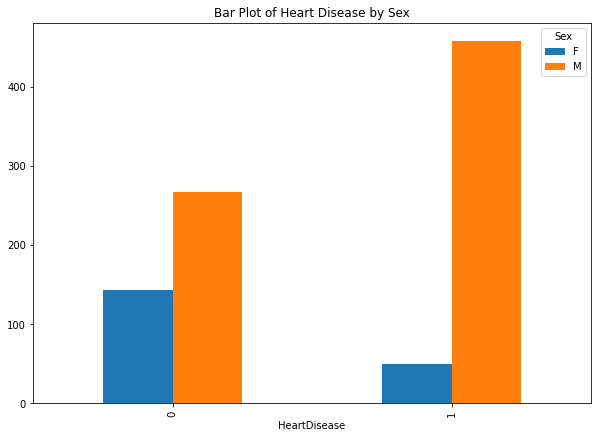

In [360]:
cat_data = pd_heart[['HeartDisease', 'Sex', 'ChestPainType', 'FastingBS',
                     'RestingECG', 'ExerciseAngina', 'ST_Slope']]
table = pd.crosstab(cat_data.HeartDisease, cat_data.Sex)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Sex")
plt.show()

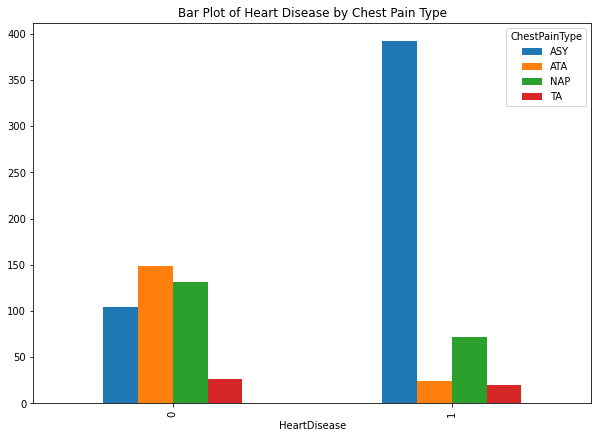

In [363]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.ChestPainType)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Chest Pain Type")
plt.show()

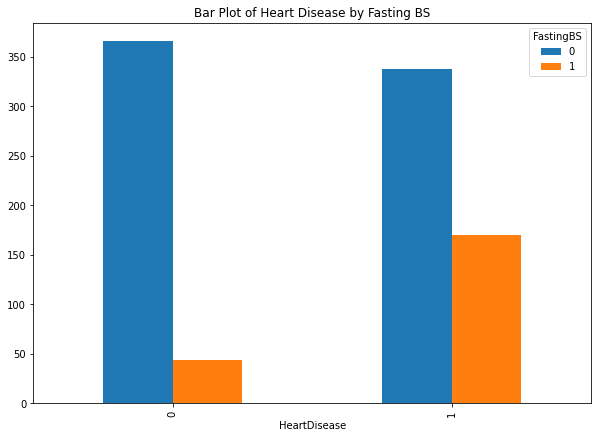

In [364]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.FastingBS)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Fasting BS")
plt.show()

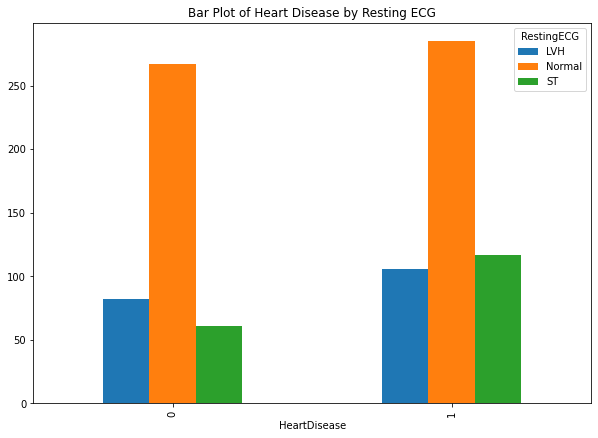

In [365]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.RestingECG)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Resting ECG")
plt.show()

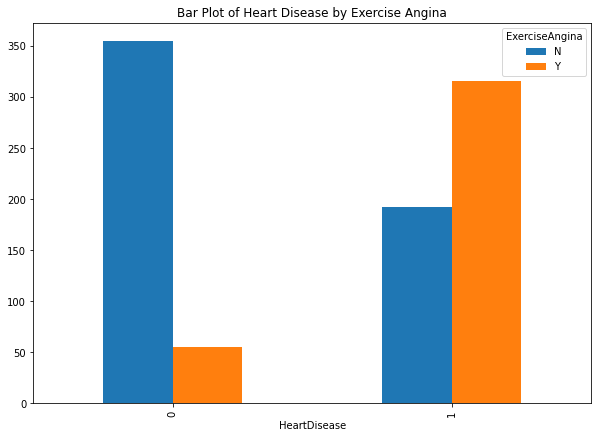

In [366]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.ExerciseAngina)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Exercise Angina")
plt.show()

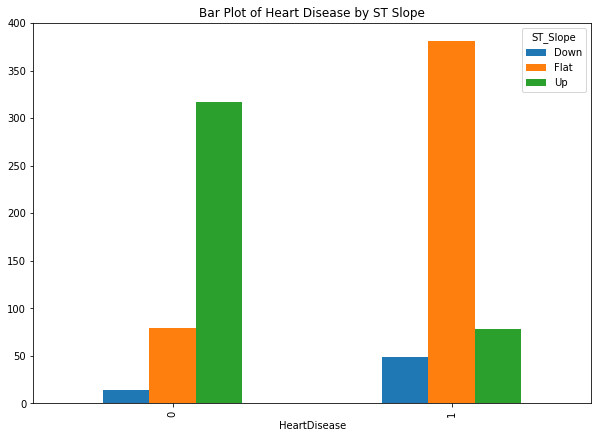

In [367]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.ST_Slope)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by ST Slope")
plt.show()

### Modeling

In [378]:
# convert categorical variables into `category` type variable
psdf_heart.Sex = psdf_heart.Sex.astype("category")
psdf_heart.ChestPainType = psdf_heart.ChestPainType.astype("category")
psdf_heart.RestingECG = psdf_heart.RestingECG.astype("category")
psdf_heart.ExerciseAngina = psdf_heart.ExerciseAngina.astype("category")
psdf_heart.ST_Slope = psdf_heart.ST_Slope.astype("category")
psdf_heart.HeartDisease = psdf_heart.HeartDisease.astype("category")

sql_full_heart = psdf_heart.to_spark()
sql_full_heart.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- ChestPainType: integer (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: integer (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: integer (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: integer (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [392]:
from pyspark.ml.feature import SQLTransformer

In [380]:
sqlTrans = SQLTransformer(
    statement = "SELECT Age, Sex, ChestPainType, log(RestingBP) as log_RestingBP," + 
                "log(Cholesterol) as log_Cholesterol, FastingBS, RestingECG," +
                "log(MaxHR) as log_MaxHR, ExerciseAngina, Oldpeak, ST_Slope," +
                "HeartDisease as label FROM __THIS__"
)

In [391]:
sqlTrans.transform(sql_full_heart).show(5)

+---+---+-------------+------------------+-----------------+---------+----------+-----------------+--------------+-------+--------+-----+
|Age|Sex|ChestPainType|     log_RestingBP|  log_Cholesterol|FastingBS|RestingECG|        log_MaxHR|ExerciseAngina|Oldpeak|ST_Slope|label|
+---+---+-------------+------------------+-----------------+---------+----------+-----------------+--------------+-------+--------+-----+
| 40|  1|            1| 4.941642422609304|5.666426688112432|        0|         1|5.147494476813453|             0|    0.0|       2|    0|
| 49|  0|            2| 5.075173815233827| 5.19295685089021|        0|         1|5.049856007249537|             0|    1.0|       1|    1|
| 37|  1|            1| 4.867534450455582|5.645446897643238|        0|         2|4.584967478670572|             0|    0.0|       2|    0|
| 48|  0|            0| 4.927253685157205|5.365976015021851|        0|         1| 4.68213122712422|             1|    1.5|       1|    1|
| 54|  1|            2|5.010635294

In [393]:
from pyspark.ml.feature import VectorAssembler

In [394]:
assembler = VectorAssembler(inputCols = ["Age", "Sex", "ChestPainType", "log_RestingBP",
                                         "log_Cholesterol", "FastingBS", "RestingECG",
                                         "log_MaxHR", "ExerciseAngina", "Oldpeak",
                                         "ST_Slope"],
                            outputCol = "features",
                            handleInvalid = 'keep')

In [395]:
assembler.transform(
    sqlTrans.transform(sql_full_heart)
).select("label", "features").show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[40.0,1.0,1.0,4.9...|
|    1|[49.0,0.0,2.0,5.0...|
|    0|[37.0,1.0,1.0,4.8...|
|    1|[48.0,0.0,0.0,4.9...|
|    0|[54.0,1.0,2.0,5.0...|
+-----+--------------------+
only showing top 5 rows



In [402]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler()\
    .setInputCol("vectorized_features")\
    .setOutputCol("features")

In [ ]:
from pyspark.ml.feature import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
encoder = OneHotEncoder(inputCols=["Sex", ""],
                        outputCols=["categoryVec1", "categoryVec2"])
model = encoder.fit(sql_heart)
encoded = model.transform(sql_heart)
encoded.show()

In [416]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

In [417]:
lgr_model = log_reg.fit(assembler.transform(sqlTrans.transform(sql_full_heart)
                                           ).select("label", "features")
)

TypeError: LogisticRegression.fit() missing 1 required positional argument: 'y'

#### Pipeline

In [266]:
from pyspark.ml import Pipeline

In [ ]:
pipeline = Pipeline(stages = [sqlTrans, assembler,
                              log_reg])

In [ ]:
ss = StandardScaler()
ss.fit(X_train)

X_train = ss.transform(X_train)  ## fit_transform can be used on the train set
X_test = ss.transform(X_test)  ## ONLY .transform method should be used

In [ ]:
### Classification Tree

In [ ]:
### Random Forest

## Conclusion